# MACD - Strategy - Backtesting 

### Import Library

In [399]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

### Load Price Data

In [400]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [401]:
data = dataset.copy()

In [402]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [403]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-11-04 14:10:00,1890.7,1891.0,1885.5,1887.3,5379
2025-11-04 14:15:00,1887.2,1899.0,1887.2,1898.5,13871
2025-11-04 14:20:00,1898.2,1907.7,1897.0,1904.2,16090


In [404]:
def cal_signal(r):
    signal = ''
    if r['can_long'] == True and r['MACDh'] < 0 and r['after_min_MACDh'] == True and r['after_negative_MACDh_series'] == True and r["Close"] > r["prev_Open"] and r["Close"] - r["prev_Low"] < 5:
        signal = 'long'
    elif r['can_short'] == True and r['MACDh'] > 0 and r['after_max_MACDh'] == True and r['after_positive_MACDh_series'] == True and r["Close"] < r["prev_Open"] and r["prev_High"] - r["Close"] < 5:
        signal = 'short'
    return signal

def prepare_data(df):
    macd = ta.macd(df["Close"], fast=12, slow=26, signal=9)
    df = pd.concat([df, macd], axis=1)
    df.rename(columns={'MACD_12_26_9': 'MACD', 'MACDh_12_26_9': 'MACDh', 'MACDs_12_26_9': 'MACDs'}, inplace=True)
    df['ibs'] = df.apply(lambda r: (r["Close"] - r["Low"]) / (r["High"] - r["Low"]), axis=1)
    df['is_max_MACDh'] = df['MACDh'] == df['MACDh'].rolling(10).max()
    df['after_max_MACDh'] = df['is_max_MACDh'].shift(1)
    df['after_positive_MACDh_series'] = df['MACDh'].rolling(5).sum() > 0
    df['is_min_MACDh'] = df['MACDh'] == df['MACDh'].rolling(10).min()
    df['after_negative_MACDh_series'] = df['MACDh'].rolling(5).sum() < 0
    df['after_min_MACDh'] = df['is_min_MACDh'].shift(1)
    df['prev_Open'] = df['Open'].shift(1)
    df['prev_Close'] = df['Close'].shift(1)
    df['prev_High'] = df['High'].shift(1)
    df['prev_Low'] = df['Low'].shift(1)
    df['max_5'] = df['High'].rolling(5).max()
    df['min_5'] = df['Low'].rolling(5).min()
    # df = df[(100 * df.index.hour + df.index.minute != 1130) & (100 * df.index.hour + df.index.minute != 1430) & (100 * df.index.hour + df.index.minute != 1445)]
    df['can_short'] = df['Open'].shift(1) <= df['Close'].shift(1)
    df['can_long'] = df['Open'].shift(1) >= df['Close'].shift(1)
    df['signal'] = df.apply(lambda r: cal_signal(r), axis=1)
    return df

In [405]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [406]:
prepared_data

,Open,High,Low,Close,Volume,MACD,MACDh,MACDs,ibs,is_max_MACDh,...,after_min_MACDh,prev_Open,prev_Close,prev_High,prev_Low,max_5,min_5,can_short,can_long,signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-02 13:10:00,899.2,900.4,898.9,899.3,1911,-0.247453,0.295880,-0.543333,0.266667,False,...,False,898.6,899.4,899.7,898.0,900.4,897.1,True,False,
2020-11-02 13:15:00,899.4,899.4,896.3,896.9,2723,-0.357929,0.148323,-0.506252,0.193548,False,...,False,899.2,899.3,900.4,898.9,900.4,896.3,True,False,
2020-11-02 13:20:00,896.9,897.5,896.4,897.4,2973,-0.400520,0.084586,-0.485106,0.909091,False,...,False,899.4,896.9,899.4,896.3,900.4,896.3,False,True,
2020-11-02 13:25:00,897.4,898.5,896.4,896.7,2420,-0.485164,-0.000047,-0.485117,0.142857,False,...,False,896.9,897.4,897.5,896.4,900.4,896.3,True,False,
2020-11-02 13:30:00,896.6,898.4,896.6,898.3,1802,-0.418317,0.053440,-0.471757,0.944444,False,...,False,897.4,896.7,898.5,896.4,900.4,896.3,False,True,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-04 14:05:00,1888.7,1891.0,1885.0,1890.2,6530,5.259522,3.931846,1.327676,0.866667,False,...,False,1887.9,1889.8,1892.0,1884.0,1899.0,1871.0,True,False,
2025-11-04 14:10:00,1890.7,1891.0,1885.5,1887.3,5379,5.625271,3.438075,2.187195,0.327273,False,...,False,1888.7,1890.2,1891.0,1885.0,1899.0,1883.0,True,False,
2025-11-04 14:15:00,1887.2,1899.0,1887.2,1898.5,13871,6.741167,3.643178,3.097990,0.957627,False,...,False,1890.7,1887.3,1891.0,1885.5,1899.0,1883.0,False,True,


In [407]:
class MainStrategy(Strategy):
    SL = 0.0032
    RR = 2
    trailing_sl = 4.5
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        signal = self.data.signal[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        ibs = self.data.ibs[-1]
        #
        # if self.position.is_long:
        #     max_5 = self.data.max_5[-1]
        #     if close_price < max_5 - self.trailing_sl:
        #         self.position.close()
        # elif self.position.is_short:
        #     min_5 = self.data.min_5[-1]
        #     if close_price > min_5 + self.trailing_sl:
        #         self.position.close()
        #
        if self.position:
            # if self.position.is_short:
            #     if self.data.MACDh[-1] > self.data.MACDh[-2]:
            #         self.position.close()
            # elif self.position.is_long:
            #     if self.data.MACDh[-1] < self.data.MACDh[-2]:
            #         self.position.close()
            # ----------------------------------------------------------------------------------------------------
            # if self.position.is_short:
            #     if signal == 'long':
            #         self.position.close()
            # elif self.position.is_long:
            #     if signal == 'short':
            #         self.position.close()
            # ----------------------------------------------------------------------------------------------------
            return
        #
        if not self.position:
            if signal == 'long':
                buy_price = close_price
                sl1 = buy_price - (buy_price * self.SL)
                sl2 = self.data.prev_Low[-1]
                sl = max(sl1, sl2)
                tp = buy_price + (buy_price - sl) * self.RR
                # self.buy(size=1, sl=sl)
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short':
                sell_price = close_price
                sl1 = sell_price + (sell_price * self.SL)
                sl2 = self.data.prev_High[-1]
                sl = min(sl1, sl2)
                tp = sell_price - (sl - sell_price) * self.RR
                # self.sell(size=1, sl=sl)
                self.sell(size=1, sl=sl, tp=tp)

In [408]:
bt = Backtest(prepared_data, MainStrategy, exclusive_orders=True)
stats = bt.run()

In [409]:
stats

Start                     2020-11-02 13:10:00
End                       2025-11-04 14:25:00
Duration                   1828 days 01:15:00
Exposure Time [%]                     20.1252
Equity Final [$]                    1928.8584
Equity Peak [$]                     1928.8584
Return [%]                           28.59056
Buy & Hold Return [%]               111.57567
Return (Ann.) [%]                      5.2002
Volatility (Ann.) [%]                 4.06163
CAGR [%]                              3.52724
Sharpe Ratio                          1.28032
Sortino Ratio                         2.17487
Calmar Ratio                           1.2042
Alpha [%]                             28.4378
Beta                                  0.00137
Max. Drawdown [%]                     -4.3184
Avg. Drawdown [%]                    -0.33615
Max. Drawdown Duration      316 days 20:55:00
Avg. Drawdown Duration        8 days 07:49:00
# Trades                                 2404
Win Rate [%]                      

In [410]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,Commission,ReturnPct,EntryTime,ExitTime,Duration,Tag
0,1,31,33,908.1,907.7,907.7,909.2,-0.4,0.0,-0.000440,2020-11-03 10:10:00,2020-11-03 10:20:00,0 days 00:10:00,None
1,1,35,46,908.5,906.8,906.8,912.2,-1.7,0.0,-0.001871,2020-11-03 10:30:00,2020-11-03 11:25:00,0 days 00:55:00,None
2,1,54,55,907.4,906.0,906.0,910.2,-1.4,0.0,-0.001543,2020-11-03 13:30:00,2020-11-03 13:35:00,0 days 00:05:00,None
3,1,77,81,908.1,911.0,906.8,911.0,2.9,0.0,0.003193,2020-11-04 09:55:00,2020-11-04 10:15:00,0 days 00:20:00,None
4,-1,89,91,913.0,914.3,914.3,910.7,-1.3,0.0,-0.001424,2020-11-04 10:55:00,2020-11-04 11:05:00,0 days 00:10:00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399,1,60736,60736,1893.0,1891.5,1891.5,1896.0,-1.5,0.0,-0.000792,2025-10-28 09:05:00,2025-10-28 09:05:00,0 days 00:00:00,None
2400,-1,60764,60764,1883.3,1876.8,1887.0,1876.8,6.5,0.0,0.003451,2025-10-28 11:25:00,2025-10-28 11:25:00,0 days 00:00:00,None
2401,-1,60903,60904,1905.0,1899.8,1907.6,1899.8,5.2,0.0,0.002730,2025-10-31 11:00:00,2025-10-31 11:05:00,0 days 00:05:00,None
2402,-1,60958,60959,1907.8,1899.8,1911.8,1899.8,8.0,0.0,0.004193,2025-11-03 13:05:00,2025-11-03 13:10:00,0 days 00:05:00,None


In [411]:
# bt.plot()

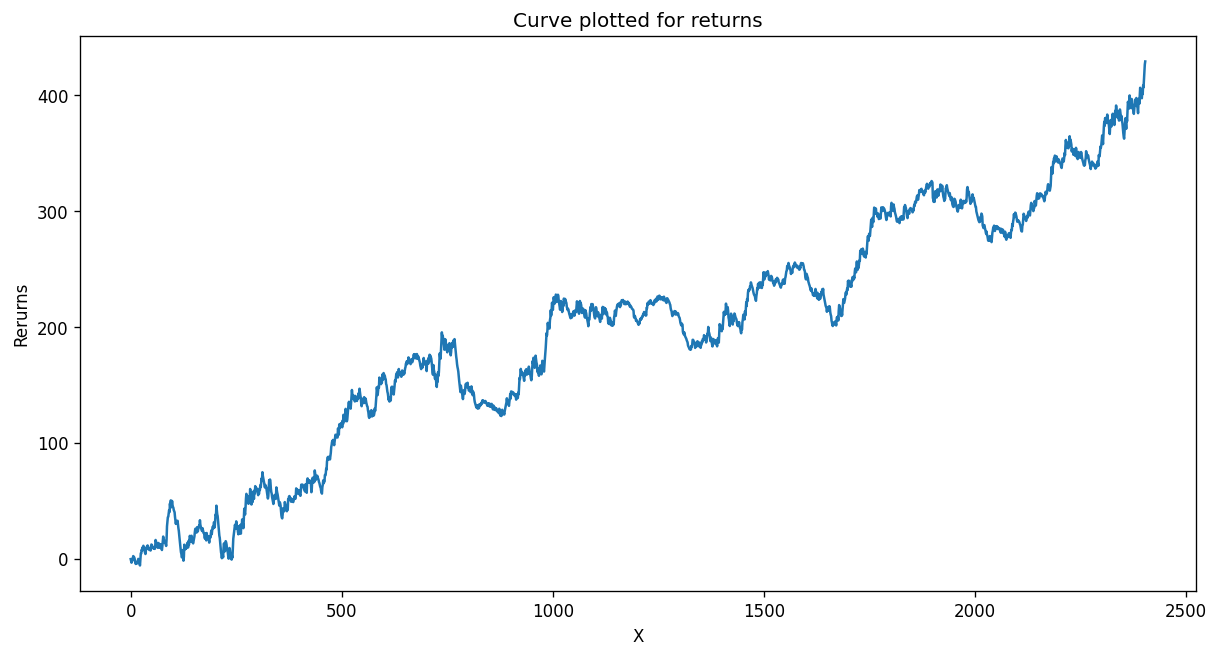

In [412]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

## Trading fee

In [413]:
copy_trades['PnL'].count() * 0.5

np.float64(1202.0)